In [596]:
"""
import modules
"""

from prepare_data import prepare_df_from_mac_5_year as prepare_CCL
from prepare_data import prepare_paths as prepare_paths
from emulate_reduction import emulator_v6 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

dir(prepare_paths)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'colors',
 'combine_azure_ctax',
 'np',
 'os',
 'output_costs_timer',
 'pd',
 'plot_MAC',
 'plt',
 'prepare_data',
 'pym',
 'truncate_colormap',
 'world_MAC_data',
 'world_emulator_data']

In [3]:
"""
load data (cubic cubicroot linear and IAMC)
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

In [490]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2090
region = 2
TIMERSTEP = 10
test_size = 0.2
stepsize_ctax_paths = 10
number_of_weights = 2

['2020' '2030' '2040' '2050' '2060' '2070' '2080' '2090' '2100']


,2020,2030,2040,2050,2060,2070,2080,2090,reduction
1460,0.0,2519.842100,3174.802104,3634.241186,4000.000000,4000.000000,4000.000000,4000.000000,112.871715
1461,0.0,2339.214191,2947.225199,3373.730661,3713.271067,4000.000000,4000.000000,4000.000000,113.759368
1462,0.0,2201.284833,2773.445097,3174.802104,3494.321859,3764.144116,4000.000000,4000.000000,112.908912
1463,0.0,2091.031834,2634.535024,3015.789765,3319.306133,3575.614140,3799.657006,4000.000000,113.248738
1464,0.0,2000.000000,2519.842100,2884.499141,3174.802104,3419.951893,3634.241186,3825.862366,113.109551


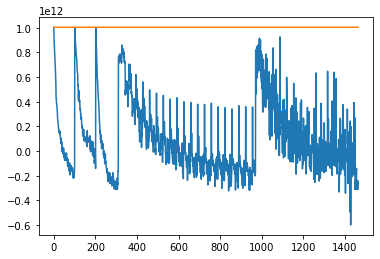

In [491]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_paths)

# load reduction from azure output
emissions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['region', 'ctax_index'] + years  # dont know how to set headers for multi-index
emissions = emissions.iloc[:, 1:]
emissions.columns = columns

year_world = 2091

baseline = emissions.loc[emissions.ctax_index == 0]
world_baseline = emissions.loc[emissions.ctax_index == 0][year_world].sum()

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths_test.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_paths.combine_azure_ctax(year, region, ctax_paths, emissions, baseline)
data_for_emulator_world = prepare_paths.world_emulator_data(year_world, ctax_paths, emissions, world_baseline)

data_1 = pd.concat([data_for_emulator_world[:310], data_for_emulator_world[1449:1464]])  #only lin cubic and root
data_2 = data_for_emulator_world[311:970]  #only scaled IAMC
data_3 = data_for_emulator_world[971:1448]  #only random

# prepare_paths.plot_MAC(data_for_emulator)
data_for_emulator_world.tail()

In [401]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_CCL)

lin_reduction = prepare_CCL.reduction_df(df_linear, year, region)
cubic_reduction = prepare_CCL.reduction_df(df_cubic, year, region)
root_reduction = prepare_CCL.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_CCL.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_CCL.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_CCL.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2030


,2020,2030,reduction
196,0.0,3920.0,46.2412
197,0.0,3940.0,46.2706
198,0.0,3960.0,46.3008
199,0.0,3980.0,46.3321
200,0.0,4000.0,46.3634


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:126: RuntimeWarning: divide by zero encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v5.py:126: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


weights dataframe: 
             0          1  ctax
0    0.000000   0.000000     0
1    0.000000   0.000000   200
2   -5.419251 -22.331713   400
3  -10.638699 -26.969881   600
4   -6.795803 -12.048899   800
5   -6.713935  -8.583202  1000
6   -1.873588 -21.145185  1200
7   -0.296919 -20.017519  1400
8   -0.122910  -9.941101  1600
9   -0.306888  -8.936930  1800
10  -2.486966  -4.393686  2000
11   7.769437 -32.869659  2200
12 -11.597965  12.416885  2400
13  -0.007099  -6.531191  2600
14   0.164643  -5.963281  2800
15  -4.071535  -0.549512  3000
16  -2.833388  -2.060029  3200
17   0.572873  -5.889829  3400
18   2.129625  -7.110515  3600
19   0.511453  -5.212888  3800
20   0.400651  -4.674965  4000


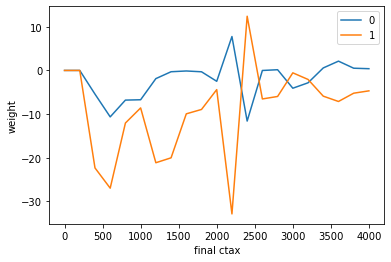

In [376]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# x = emulate.CtaxRedEmulator(year, region, lin_paths, combi, ctax_paths, test_size)

x = emulate.CtaxRedEmulator(year, region, data_for_emulator_world[0:109], data_for_emulator_world, data_for_emulator_world, ctax_paths, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
pred = x.test_ctax_paths()
# x.scatter_and_mac(pred)



In [600]:
reload(emulate)

x = emulate.CtaxRedEmulator(year, region, lin_paths, data_for_emulator_world, data_for_emulator_world, ctax_paths, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
# x.scatter_and_mac(multi_lin_regr_mod)

# # polynomial regression model
# degree = 3
# poly_regr_mod = x.train_ctax_PR(degree)

# # # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)
# lasso_plot = x.test_regr(lasso_mod)

# Regression tree
# max_depth = 5
# regr_tree = x.train_ctax_tree(max_depth)

# # Random forest
# regr_forest = x.train_ctax_forest(max_depth)
# # forest_plot = x.test_regr(regr_forest)
# # x.scatter_and_mac(regr_forest)

# # SVM
# svm_regr = x.train_SVM()
# svm_plot = x.test_regr(svm_regr)
# x.scatter_and_mac(svm_regr)

# # MLPRegressor
# MLP_regr = x.train_MLPRegressor()
# MLP_plot = x.test_regr(MLP_regr)

# TensorFlow
# TF_regr = x.train_TF()



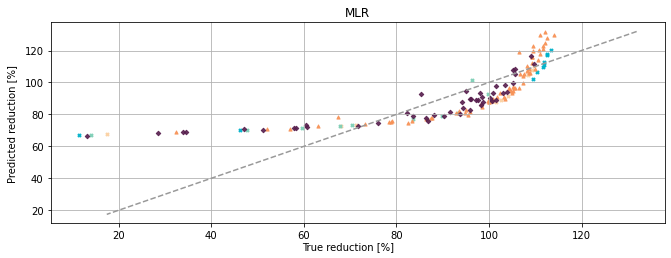

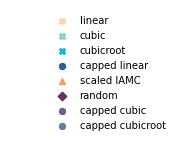

In [601]:
"""
RMSE and R-squared dataframe
"""
score = x.score()
score.to_clipboard(excel=True)
x.pred_vs_true()

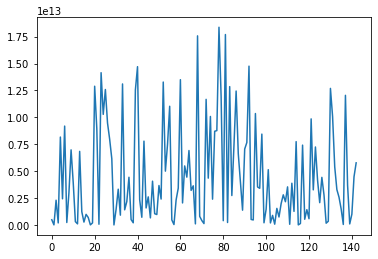

In [602]:
x.calc_miti_emu(world_baseline, 40)

,region,ctax_index,1971,1981,1991,2001,2011,2021,2031,2041,2051,2061,2071,2081,2091,2100
0,1,0,8.969030e+10,1.117960e+11,1.169163e+11,1.406543e+11,1.487516e+11,1.577254e+11,1.564376e+11,1.496844e+11,1.536143e+11,1.411263e+11,1.459626e+11,1.584969e+11,1.367588e+11,1.192841e+11
1,2,0,1.110139e+12,1.245669e+12,1.299780e+12,1.512515e+12,1.474906e+12,1.395895e+12,1.345834e+12,1.350751e+12,1.349900e+12,1.162343e+12,1.081553e+12,1.027938e+12,9.156419e+11,8.441872e+11
2,3,0,3.019588e+10,6.728479e+10,8.076364e+10,1.000094e+11,1.319134e+11,1.435511e+11,1.534017e+11,1.534467e+11,1.620830e+11,1.694773e+11,1.819841e+11,2.092976e+11,1.786412e+11,1.634706e+11
3,4,0,2.121353e+10,2.690361e+10,2.661901e+10,3.867272e+10,4.919659e+10,5.919332e+10,7.899564e+10,1.014549e+11,1.167633e+11,1.318694e+11,1.619545e+11,1.960358e+11,1.838207e+11,1.764025e+11
4,5,0,2.441268e+10,5.178711e+10,6.683297e+10,9.672262e+10,1.356199e+11,1.484881e+11,1.507030e+11,1.502721e+11,1.356940e+11,1.318862e+11,1.561332e+11,1.684530e+11,1.338708e+11,1.120747e+11


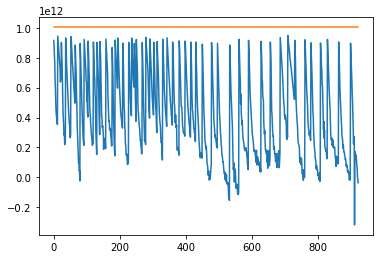

In [497]:
"""
emulate miti costs and compare to TIMER == TRUE 
"""
reload(emulate)
reload(prepare_paths)

# load TIMER miticosts set
miti_timer = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/random_scaled_mym/co2tax.csv', index_col=0)
columns = ['region', 'ctax_index'] + years
miti_timer.columns = columns
ctax_paths_miti = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/random_scaled_mym/scaled_random.xlsx', index_col=[0])
ctax_paths_miti.index.name = 'ctax_index' 
compare_miti = prepare_paths.combine_azure_ctax(year, region, ctax_paths_miti, miti_timer, baseline)

emu_method = 'SVM'
step_ctax = 40
# x.calc_miti_costs(emu_method, region, step_ctax, miti_timer, baseline, compare_miti)

miti_timer.head()


In [498]:
# all seperate scaled random df's
x.calc_miti_timer(ctax_paths_miti, compare_miti, baseline)
x.calc_miti_emu(ctax_paths_miti, compare_miti, baseline)
x.plot_timer_vs_emu()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 165 is different from 8)

KeyError: "None of [Index(['2020', '2030'], dtype='object')] are in the [index]"